# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

###
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = 'drive/MyDrive/Final_Project_Data/pituitary_tumor/' # Class as 4

#import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset


In [2]:
indx=0
images = []
labels = []

labels_index = 0

for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, [1,0,0,0]))
    labels_index = idx

normal_index = labels_index + 1

for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, [0,1,0,0]))
    labels_index = idx

glioma_index = normal_index + labels_index + 1

for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, [0,0,1,0]))
    labels_index = idx

meningioma_index = glioma_index + labels_index + 1

for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, [0,0,0,1]))


In [3]:
labels = np.array(labels)
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'Label'])

<ipython-input-3-651425286c1d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(labels)


## From Cornelia's Diabetic Retinopathy Notebook:

As you can see from the histogram above, our dataset is very imbalanced, which is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for starters.

`Correct for data imbalance`

In [4]:
np.random.seed(1234)

n_size = 80


# randomly draw 438 images from each classes
temp_normal = list(np.random.choice(
    normal_index,
    size=n_size,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma_index,
    size=n_size,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma_index,
    size=n_size,
    replace=False
))


temp_pituitary = list(np.random.choice(
    len(labels),
    size=n_size,
    replace=False
))

In [5]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [6]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  320
Length of Labels List:  320


In [7]:
images_mini = []
y_mini = []

for img in image_list:

# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)

images_mini = np.stack(images_mini)

for label in labels_list:
    y_mini.append(label[1])

y_mini = np.array(y_mini)

In [8]:
images_mini.shape

(320, 256, 256, 3)

In [9]:
y_mini.shape

(320, 4)

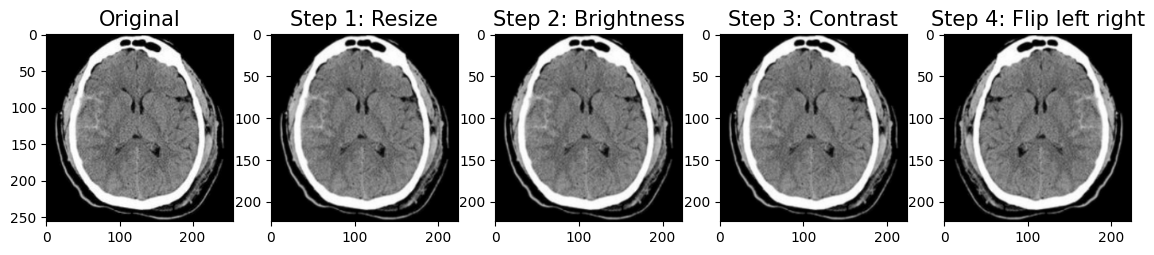

In [7]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [10]:
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    return X_train, y_train, X_val, y_val, X_test, y_test

def preprocess_data_part2_aug(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)

    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 256, 256, 3)
y_train shape (192, 4)
X_val shape (64, 256, 256, 3)
y_val shape (64, 4)
X_test shape (64, 256, 256, 3)
y_test shape (64, 4)


In [30]:
validate_split = pd.DataFrame(y_train)

In [31]:
validate_split.value_counts()

0  1  2  3
1  0  0  0    84
0  1  0  0    66
   0  1  0    28
      0  1    14
dtype: int64

In [12]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=4,
    name='fc_2',
    activation='softmax'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 256, 256, 3))
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy", #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy'])

# set random seed to get reproductible results
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=15,
                    validation_data=(X_val, y_val)
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 128, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              268436480 
                                                                 
 dropout (Dropout)           (None, 1024)              0

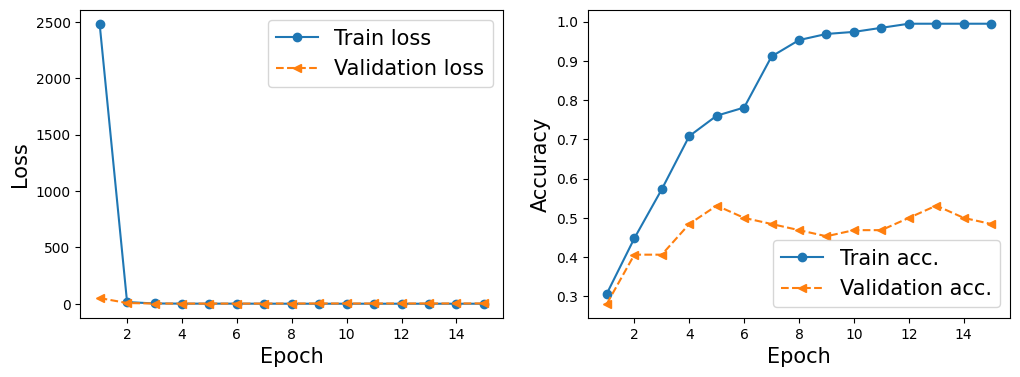

In [13]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [14]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

2/2 [==============================] - 4s 2s/step - loss: 2.9575 - accuracy: 0.5469

Test Acc. 54.69%


In [15]:
pred_labels = model.predict(X_test)

2/2 [==============================] - 7s 3s/step


In [20]:
pred_labels = (pred_labels == pred_labels.max(axis=1)[:,None]).astype(int)

ValueError: ignored

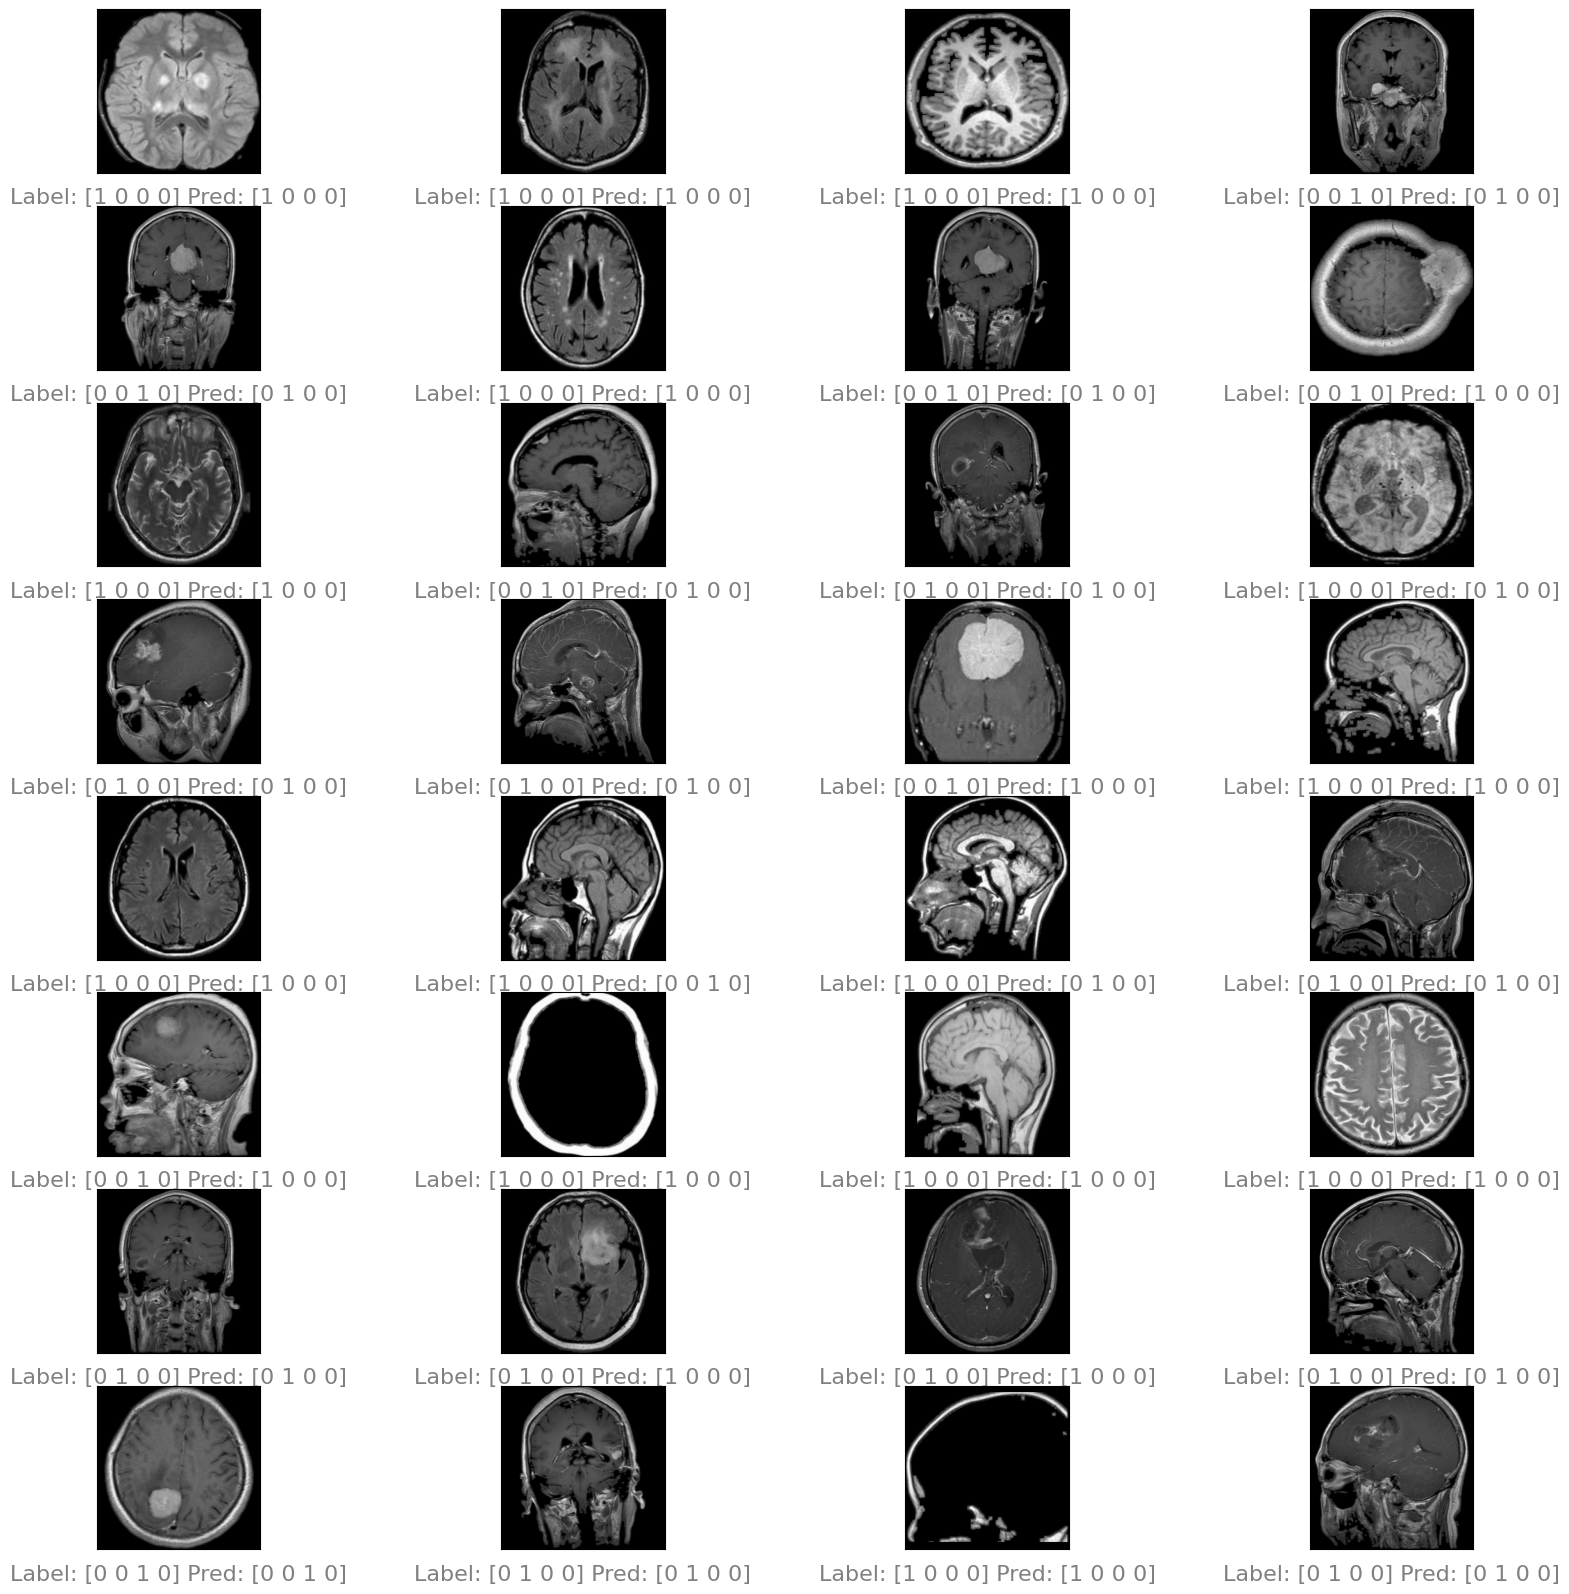

In [22]:
# plot test data and associated predicred
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_test):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    label = str(y_test[j])


    ax.text(
        0.5, -0.15,
        'Label: {:s} Pred: {:s}'.format(label, str(pred_labels[j])),
        size=16,
        color='grey',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()
plt.show()